In [ ]:
from google.colab import files

# Upload the notebook file
uploaded = files.upload()


In [1]:
!pip install tensorflow

In [2]:
# Download TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the files
!tar -xzf ta-lib-0.4.0-src.tar.gz

# Navigate to the directory
%cd ta-lib/

# Configure and install
!./configure --prefix=/usr
!make
!make install

# Go back to the parent directory
%cd ..

# Install the Python wrapper for TA-Lib
!pip install ta-lib

--2024-07-04 05:46:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-07-04 05:46:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-07-04 05:46:37--  http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1

1 Physical GPUs, 1 Logical GPUs
Is TensorFlow using GPU: True
Is GPU available: True
Epoch 1/100
597/597 [==============================] - 30s 31ms/step - loss: 0.9271 - accuracy: 0.2824 - val_loss: 0.7849 - val_accuracy: 0.4566 - lr: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


597/597 [==============================] - 17s 28ms/step - loss: 0.9186 - accuracy: 0.2956 - val_loss: 0.7684 - val_accuracy: 0.5385 - lr: 1.0000e-04
Epoch 3/100
597/597 [==============================] - 18s 30ms/step - loss: 0.9164 - accuracy: 0.2954 - val_loss: 0.7927 - val_accuracy: 0.4840 - lr: 1.0000e-04
Epoch 4/100
597/597 [==============================] - 17s 29ms/step - loss: 0.9147 - accuracy: 0.2931 - val_loss: 0.7673 - val_accuracy: 0.5365 - lr: 1.0000e-04
Epoch 5/100
597/597 [==============================] - 18s 30ms/step - loss: 0.9140 - accuracy: 0.3010 - val_loss: 0.7715 - val_accuracy: 0.4904 - lr: 1.0000e-04
Epoch 6/100
597/597 [==============================] - 18s 29ms/step - loss: 0.9133 - accuracy: 0.2999 - val_loss: 0.7953 - val_accuracy: 0.3925 - lr: 1.0000e-04
Epoch 7/100
597/597 [==============================] - 19s 32ms/step - loss: 0.9121 - accuracy: 0.3058 - val_loss: 0.7422 - val_accuracy: 0.5773 - lr: 1.0000e-04
Epoch 8/100
597/597 [===================

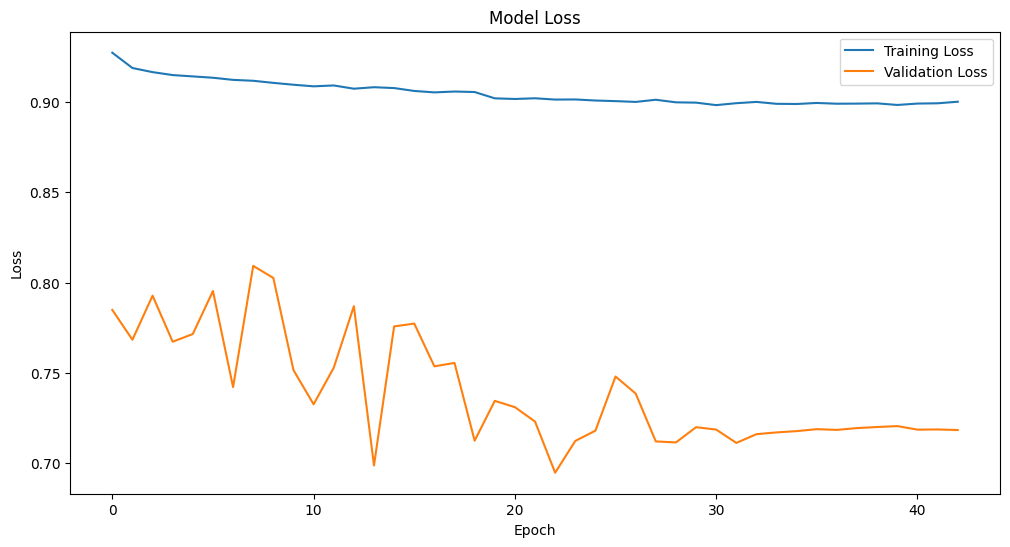

1493/1493 [==============================] - 15s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83     42770
           1       0.19      0.53      0.28      4979

    accuracy                           0.72     47749
   macro avg       0.56      0.64      0.56     47749
weighted avg       0.85      0.72      0.77     47749



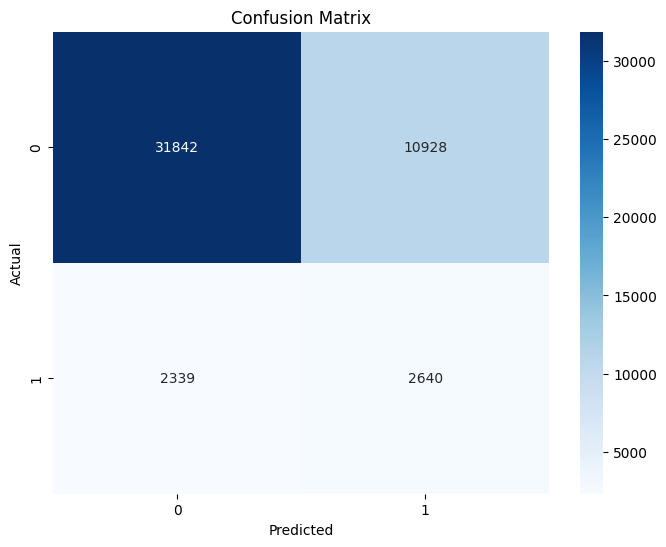

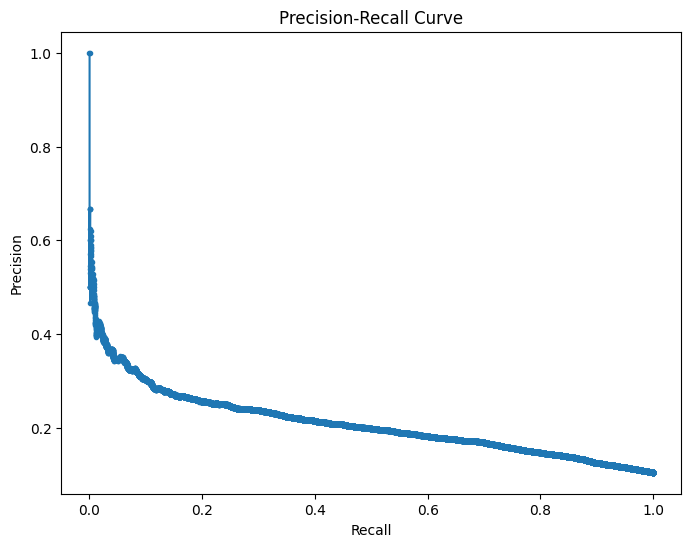

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import talib
import logging
from sklearn.metrics import precision_recall_curve

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("Is TensorFlow using GPU:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def aggregate_to_5min(data, output_filename='SPY_data_5_min.csv'):
    """Aggregate 1-minute data to 5-minute intervals, removing rows with missing OHLC data, and save to CSV."""
    logging.info("Aggregating 1-minute data to 5-minute intervals...")

    # Remove rows where any OHLC data is missing
    data = data.dropna(subset=['open', 'high', 'low', 'close'])

    # Ensure the index is datetime
    data.index = pd.to_datetime(data.index)

    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }

    data_5min = data.resample('5T').agg(agg_dict)

    # Remove any aggregated rows with NaN values
    data_5min = data_5min.dropna()

    # Save the aggregated data to a CSV file
    data_5min.to_csv(output_filename)

    logging.info(f"Original data shape: {data.shape}")
    logging.info(f"Aggregated data shape: {data_5min.shape}")
    logging.info(f"Aggregated data saved to {output_filename}")

    return data_5min

def create_features(data):
    logging.info(f"Creating features. Input data shape: {data.shape}")
    features = pd.DataFrame(index=data.index)

    # Basic features
    features['returns'] = data['close'].pct_change()
    features['log_return'] = np.log(data['close'] / data['close'].shift(1))
    features['volume_change'] = data['volume'].pct_change()

    # Technical indicators
    features['rsi'] = talib.RSI(data['close'])
    features['macd'], _, _ = talib.MACD(data['close'])
    features['adx'] = talib.ADX(data['high'], data['low'], data['close'])
    features['cci'] = talib.CCI(data['high'], data['low'], data['close'])
    features['obv'] = talib.OBV(data['close'], data['volume'])
    features['atr'] = talib.ATR(data['high'], data['low'], data['close'])
    features['mfi'] = talib.MFI(data['high'], data['low'], data['close'], data['volume'])

    # Moving averages
    for window in [10, 30, 50]:
        features[f'sma_{window}'] = data['close'].rolling(window=window, min_periods=1).mean()
        features[f'ema_{window}'] = data['close'].ewm(span=window, adjust=False, min_periods=1).mean()

    # Bollinger Bands
    features['bb_upper'], features['bb_middle'], features['bb_lower'] = talib.BBANDS(data['close'])

    # Replace infinite values with NaN and then fill NaN values
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(method='ffill').fillna(method='bfill')

    logging.info(f"Features created. Output shape: {features.shape}")
    return features

def prepare_data(features, sequence_length=60, threshold=0.001):
    logging.info(f"Preparing data. Input features shape: {features.shape}")

    # Create target variable (1 if return > threshold, 0 otherwise)
    y = (features['returns'].shift(-1) > threshold).astype(int)

    # Remove the last row as it won't have a target value
    features = features[:-1]
    y = y[:-1]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y.iloc[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    logging.info(f"Final sequences - X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")
    logging.info(f"Class distribution: {np.bincount(y_seq)}")

    return X_seq, y_seq, scaler

def create_transformer_model(input_shape, num_heads=4, ff_dim=64, num_transformer_blocks=4, mlp_units=[64, 32], dropout=0.1):
    with tf.device('/GPU:0'):
        inputs = Input(shape=input_shape)
        x = inputs
        for _ in range(num_transformer_blocks):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
            attn_output = Dense(input_shape[-1])(attn_output)
            x = LayerNormalization(epsilon=1e-6)(x + attn_output)
            ff_output = Dense(ff_dim, activation="relu")(x)
            ff_output = Dense(input_shape[-1])(ff_output)
            x = LayerNormalization(epsilon=1e-6)(x + ff_output)

        x = GlobalAveragePooling1D()(x)
        for dim in mlp_units:
            x = Dense(dim, activation="relu")(x)
            x = Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)

        model = Model(inputs=inputs, outputs=outputs)
    return model

def train_model(X_train, y_train, X_val, y_val):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_transformer_model(input_shape)

    # Compute class weights with increased weight for minority class
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    class_weight_dict[1] *= 2  # Increase weight for minority class

    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict(X_test)

    # Find the best threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold = thresholds[np.argmax(f1_scores)]

    y_pred = (y_pred_proba > best_threshold).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    logging.info(f"Best Threshold: {best_threshold:.4f}")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"F1 Score: {f1:.4f}")
    logging.info(f"AUC-ROC: {auc_roc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Main execution
logging.info("Starting main execution...")

# Load the preprocessed 5-minute data
data = pd.read_csv('/content/SPY_data_5_min.csv', index_col='date', parse_dates=True)
logging.info(f"Loaded 5-minute data shape: {data.shape}")

# Create features
features = create_features(data)

# Prepare data
X, y, scaler = prepare_data(features)

# Split data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Further split training data into train and validation
    train_size = int(len(X_train) * 0.8)
    X_train, X_val = X_train[:train_size], X_train[train_size:]
    y_train, y_val = y_train[:train_size], y_train[train_size:]

    # Train model
    model = train_model(X_train, y_train, X_val, y_val)

    # Evaluate model
    evaluate_model(model, X_test, y_test)

    # Optional: Break after first fold if you don't want to run all 5 folds
    break

logging.info("Execution completed.")